# Penerapan Model XGBoost untuk Deteksi Transaksi Fraud pada Sistem Credit Card

Note:
- Menggunakan dataset baru yang belum di PCA
- Menambahkan PCA pada dataset baru
- Menyimpan model dalam format .onnx

Deskripsi: Melatih model deteksi penipuan menggunakan XGBoost
- dalam satu pipeline sklearn dengan preprocessing (Scaler & PCA).
- Model disimpan dalam format .pkl dan .onnx untuk deployment.\

In [21]:
!where python

c:\IT Journey\ML\Business Intelegent\.venv\Scripts\python.exe
C:\Users\ENIGMA\AppData\Local\Programs\Python\Python310\python.exe
C:\Users\ENIGMA\AppData\Local\Microsoft\WindowsApps\python.exe


In [30]:
!pip install numpy pandas matplotlib
!pip install scikit-learn==1.0.2
!pip install xgboost==1.6.2
!pip install onnx==1.13.0
!pip install onnxmltools==1.11.1
!pip install skl2onnx==1.14
!pip install onnxruntime


  Using cached scikit_learn-1.0.2-cp310-cp310-win_amd64.whl.metadata (10 kB)
Using cached scikit_learn-1.0.2-cp310-cp310-win_amd64.whl (7.2 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.0
    Uninstalling scikit-learn-1.3.0:
      Successfully uninstalled scikit-learn-1.3.0


  You can safely remove it manually.


  Using cached xgboost-1.6.2-py3-none-win_amd64.whl.metadata (1.8 kB)
Using cached xgboost-1.6.2-py3-none-win_amd64.whl (125.4 MB)
  Attempting uninstall: xgboost
    Found existing installation: xgboost 1.7.6
    Uninstalling xgboost-1.7.6:
      Successfully uninstalled xgboost-1.7.6


  You can safely remove it manually.


  Using cached onnx-1.13.0-cp310-cp310-win_amd64.whl.metadata (14 kB)
Using cached onnx-1.13.0-cp310-cp310-win_amd64.whl (12.2 MB)
  Attempting uninstall: onnx
    Found existing installation: onnx 1.14.1
    Uninstalling onnx-1.14.1:
      Successfully uninstalled onnx-1.14.1


  You can safely remove it manually.


  Using cached onnxmltools-1.11.1-py3-none-any.whl.metadata (9.2 kB)
Using cached onnxmltools-1.11.1-py3-none-any.whl (308 kB)
  Attempting uninstall: onnxmltools
    Found existing installation: onnxmltools 1.11.2
    Uninstalling onnxmltools-1.11.2:
      Successfully uninstalled onnxmltools-1.11.2
  Using cached skl2onnx-1.14.0-py2.py3-none-any.whl.metadata (2.1 kB)
Using cached skl2onnx-1.14.0-py2.py3-none-any.whl (294 kB)
  Attempting uninstall: skl2onnx
    Found existing installation: skl2onnx 1.15.0
    Uninstalling skl2onnx-1.15.0:
      Successfully uninstalled skl2onnx-1.15.0


In [22]:
# IMPORT LIBRARIES
import os
import sys
import json
import warnings
from pathlib import Path
import shutil

# Import libraries
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    f1_score, accuracy_score, precision_score, recall_score
)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import joblib
from xgboost import XGBClassifier
import xgboost as xgb
import onnx
import onnxruntime as ort
from skl2onnx import convert_sklearn
from onnxmltools.convert.common.data_types import FloatTensorType

warnings.filterwarnings('ignore')

print("FRAUD DETECTION MODEL - COMPLETE PIPELINE")

FRAUD DETECTION MODEL - COMPLETE PIPELINE


In [23]:
# 1. SETUP PATHS

print("\n[1/10] Setting up paths...")

# Create model directory
MODEL_PATH = 'models_pipeline'
os.makedirs(MODEL_PATH, exist_ok=True)
print(f"Model path: {MODEL_PATH}")


[1/10] Setting up paths...
Model path: models_pipeline


In [27]:
# 2. DATA LOADING & PREPROCESSING

print("\n[2/10] Loading and preprocessing data...")

DATASET_PATH = 'dataset-fraud'
df_train = pd.read_csv(os.path.join(DATASET_PATH, 'fraudTrain.csv'))
df_test = pd.read_csv(os.path.join(DATASET_PATH, 'fraudTest.csv'))

print(f"Training data: {df_train.shape}")
print(f"Test data: {df_test.shape}")

# Preprocessing function
def preprocess_data(df, label_encoders=None, fit=True):
    """Preprocess fraud detection dataset"""
    X = df.drop(columns=['is_fraud'])
    y = df['is_fraud']
    
    # Drop unnecessary columns
    cols_to_drop = ['Unnamed: 0', 'trans_num', 'unix_time', 'first', 'last', 
                    'street', 'merchant', 'job']
    cols_to_drop = [col for col in cols_to_drop if col in X.columns]
    X = X.drop(columns=cols_to_drop)
    
    # Datetime features
    if 'trans_date_trans_time' in X.columns:
        X['trans_date_trans_time'] = pd.to_datetime(X['trans_date_trans_time'])
        X['hour'] = X['trans_date_trans_time'].dt.hour
        X['dayofweek'] = X['trans_date_trans_time'].dt.dayofweek
        X['month'] = X['trans_date_trans_time'].dt.month
        X = X.drop(columns=['trans_date_trans_time'])
    
    # Age from DOB
    if 'dob' in X.columns:
        X['dob'] = pd.to_datetime(X['dob'])
        X['age'] = (pd.Timestamp.now() - X['dob']).dt.days // 365
        X = X.drop(columns=['dob'])
    
    # Categorical encoding
    categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
    
    if fit:
        encoders = {}
        for col in categorical_cols:
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col].astype(str))
            encoders[col] = le
        return X, y, encoders
    else:
        for col in categorical_cols:
            le = label_encoders[col]
            X[col] = X[col].astype(str).map(
                lambda x: le.transform([x])[0] if x in le.classes_ else -1
            )
        return X, y

# Preprocess data
X_train, y_train, label_encoders = preprocess_data(df_train, fit=True)
X_test, y_test = preprocess_data(df_test, label_encoders=label_encoders, fit=False)

print(f"X_train: {X_train.shape}, Fraud: {y_train.mean()*100:.2f}%")
print(f"X_test: {X_test.shape}, Fraud: {y_test.mean()*100:.2f}%")

# Store feature names
feature_names = X_train.columns.tolist()
print(f"Features ({len(feature_names)}): {feature_names}")


[2/10] Loading and preprocessing data...
Training data: (1296675, 23)
Test data: (555719, 23)
X_train: (1296675, 16), Fraud: 0.58%
X_test: (555719, 16), Fraud: 0.39%
Features (16): ['cc_num', 'category', 'amt', 'gender', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long', 'hour', 'dayofweek', 'month', 'age']



[2.1/10] Visualizing data distribution...
SUCCESS: Visualization saved: models_pipeline\data_distribution_analysis.png


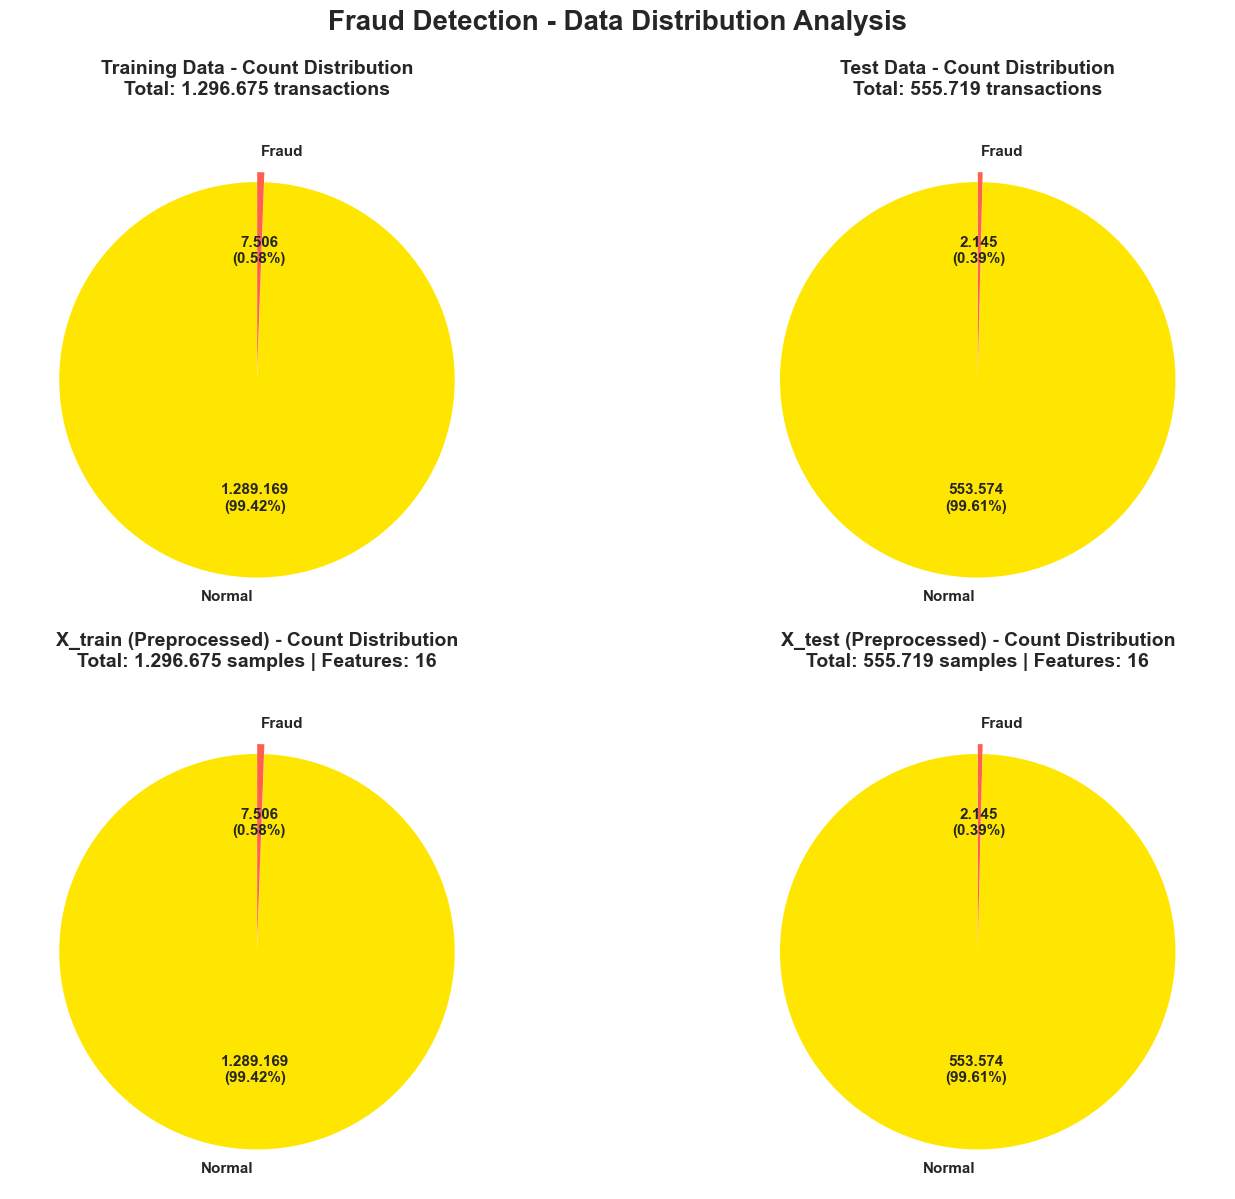

DATA DISTRIBUTION SUMMARY

Original Data:
  Training Data:
    - Total: 1.296.675 transactions
    - Normal: 1.289.169 (99.42%)
    - Fraud: 7.506 (0.58%)
    - Imbalance Ratio: 1:171.8

  Test Data:
    - Total: 555.719 transactions
    - Normal: 553.574 (99.61%)
    - Fraud: 2.145 (0.39%)
    - Imbalance Ratio: 1:258.1

Preprocessed Data:
  X_train:
    - Shape: (1296675, 16)
    - Total: 1.296.675 samples
    - Normal: 1.289.169 (99.42%)
    - Fraud: 7.506 (0.58%)
    - Features: 16

  X_test:
    - Shape: (555719, 16)
    - Total: 555.719 samples
    - Normal: 553.574 (99.61%)
    - Fraud: 2.145 (0.39%)
    - Features: 16

Data Consistency Check:
  Training data preserved: True (Original: 1.296.675 -> Preprocessed: 1.296.675)
  Test data preserved: True (Original: 555.719 -> Preprocessed: 555.719)


In [26]:
# DATA VISUALIZATION - FRAUD vs NORMAL DISTRIBUTION

print("\n[2.1/10] Visualizing data distribution...")

import matplotlib.pyplot as plt

# Setup matplotlib style
plt.style.use('seaborn-v0_8-darkgrid')
colors = ["#ffe600", "#ff5f4e"]  # Kuning untuk Normal, Merah untuk Fraud
explode = (0.05, 0)  # Sedikit memisahkan potongan fraud

# --- DATA PREPARATION ---
# Hitung semua nilai 'counts' dan 'percentages' yang diperlukan di awal
# Ini untuk visualisasi dan untuk statistik ringkasan di akhir

# Original Data
train_counts = df_train['is_fraud'].value_counts().sort_index()
train_percentages = df_train['is_fraud'].value_counts(normalize=True).sort_index() * 100

test_counts = df_test['is_fraud'].value_counts().sort_index()
test_percentages = df_test['is_fraud'].value_counts(normalize=True).sort_index() * 100

# Preprocessed Data
X_train_counts = y_train.value_counts().sort_index()
X_train_percentages = y_train.value_counts(normalize=True).sort_index() * 100

X_test_counts = y_test.value_counts().sort_index()
X_test_percentages = y_test.value_counts(normalize=True).sort_index() * 100


# Create figure with 2 rows and 2 columns
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Fraud Detection - Data Distribution Analysis', fontsize=20, fontweight='bold', y=0.995)

# ROW 1: ORIGINAL TRAINING DATA

# 1.1 Training Data - Count
# Add custom autopct with counts
def make_autopct_count(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        # Mengganti koma dengan titik untuk format angka
        return '{:,}\n({:.2f}%)'.format(val, pct).replace(',', '.')
    return my_autopct

axes[0, 0].pie(train_counts.values, 
               labels=['Normal', 'Fraud'],
               colors=colors,
               autopct=make_autopct_count(train_counts.values),
               startangle=90,
               explode=explode,
               shadow=False,
               textprops={'fontsize': 11, 'weight': 'bold'})
# Mengganti koma dengan titik pada judul
axes[0, 0].set_title('Training Data - Count Distribution\nTotal: {:,} transactions'.format(len(df_train)).replace(',', '.'), 
                     fontsize=14, fontweight='bold', pad=20)

# ROW 2: ORIGINAL TEST DATA

# 2.1 Test Data - Count
axes[0, 1].pie(test_counts.values, 
               labels=['Normal', 'Fraud'],
               colors=colors,
               autopct=make_autopct_count(test_counts.values),
               startangle=90,
               explode=explode,
               shadow=False,
               textprops={'fontsize': 11, 'weight': 'bold'})
# Mengganti koma dengan titik pada judul
axes[0, 1].set_title('Test Data - Count Distribution\nTotal: {:,} transactions'.format(len(df_test)).replace(',', '.'), 
                     fontsize=14, fontweight='bold', pad=20)

# ROW 3: PREPROCESSED X_TRAIN

# 3.1 X_train (Preprocessed) - Count
axes[1, 0].pie(X_train_counts.values, 
               labels=['Normal', 'Fraud'],
               colors=colors,
               autopct=make_autopct_count(X_train_counts.values),
               startangle=90,
               explode=explode,
               shadow=False,
               textprops={'fontsize': 11, 'weight': 'bold'})
# Mengganti koma dengan titik pada judul
axes[1, 0].set_title('X_train (Preprocessed) - Count Distribution\nTotal: {:,} samples | Features: {}'.format(len(X_train), len(feature_names)).replace(',', '.'), 
                     fontsize=14, fontweight='bold', pad=20)

# ROW 4: PREPROCESSED X_TEST

# 4.1 X_test (Preprocessed) - Count
axes[1, 1].pie(X_test_counts.values, 
               labels=['Normal', 'Fraud'],
               colors=colors,
               autopct=make_autopct_count(X_test_counts.values),
               startangle=90,
               explode=explode,
               shadow=False,
               textprops={'fontsize': 11, 'weight': 'bold'})
# Mengganti koma dengan titik pada judul
axes[1, 1].set_title('X_test (Preprocessed) - Count Distribution\nTotal: {:,} samples | Features: {}'.format(len(X_test), len(feature_names)).replace(',', '.'), 
                     fontsize=14, fontweight='bold', pad=20)

# FINAL ADJUSTMENTS

plt.tight_layout()

# Save figure
viz_path = os.path.join(MODEL_PATH, 'data_distribution_analysis.png')
plt.savefig(viz_path, dpi=300, bbox_inches='tight')
print(f"SUCCESS: Visualization saved: {viz_path}")

plt.show()

# PRINT SUMMARY STATISTICS

print("DATA DISTRIBUTION SUMMARY")

print("\nOriginal Data:")
print(f"  Training Data:")
# Mengganti koma dengan titik pada output teks
print(f"    - Total: {len(df_train):,} transactions".replace(',', '.'))
print(f"    - Normal: {train_counts[0]:,} ({train_percentages[0]:.2f}%)".replace(',', '.'))
print(f"    - Fraud: {train_counts[1]:,} ({train_percentages[1]:.2f}%)".replace(',', '.'))
print(f"    - Imbalance Ratio: 1:{train_counts[0]/train_counts[1]:.1f}")

print(f"\n  Test Data:")
# Mengganti koma dengan titik pada output teks
print(f"    - Total: {len(df_test):,} transactions".replace(',', '.'))
print(f"    - Normal: {test_counts[0]:,} ({test_percentages[0]:.2f}%)".replace(',', '.'))
print(f"    - Fraud: {test_counts[1]:,} ({test_percentages[1]:.2f}%)".replace(',', '.'))
print(f"    - Imbalance Ratio: 1:{test_counts[0]/test_counts[1]:.1f}")

print("\nPreprocessed Data:")
print(f"  X_train:")
print(f"    - Shape: {X_train.shape}")
# Mengganti koma dengan titik pada output teks
print(f"    - Total: {len(X_train):,} samples".replace(',', '.'))
print(f"    - Normal: {X_train_counts[0]:,} ({X_train_percentages[0]:.2f}%)".replace(',', '.'))
print(f"    - Fraud: {X_train_counts[1]:,} ({X_train_percentages[1]:.2f}%)".replace(',', '.'))
print(f"    - Features: {len(feature_names)}")

print(f"\n  X_test:")
print(f"    - Shape: {X_test.shape}")
# Mengganti koma dengan titik pada output teks
print(f"    - Total: {len(X_test):,} samples".replace(',', '.'))
print(f"    - Normal: {X_test_counts[0]:,} ({X_test_percentages[0]:.2f}%)".replace(',', '.'))
print(f"    - Fraud: {X_test_counts[1]:,} ({X_test_percentages[1]:.2f}%)".replace(',', '.'))
print(f"    - Features: {len(feature_names)}")

print("\nData Consistency Check:")
train_match = len(df_train) == len(X_train)
test_match = len(df_test) == len(X_test)
# Mengganti koma dengan titik pada output teks
print(f"  Training data preserved: {train_match} (Original: {len(df_train):,} -> Preprocessed: {len(X_train):,})".replace(',', '.'))
print(f"  Test data preserved: {test_match} (Original: {len(df_test):,} -> Preprocessed: {len(X_test):,})".replace(',', '.'))

## Rumus `scale_pos_weight`

$$
\text{scale\_pos\_weight} = \frac{\text{Jumlah data kelas negatif}}{\text{Jumlah data kelas positif}}
$$

Jika:

- Kelas **0** = negatif (normal)
- Kelas **1** = positif (fraud)

Maka:

$$
\text{scale\_pos\_weight} = \frac{N_0}{N_1}
$$

Dengan:
- \( N_0 \) = jumlah sampel kelas 0  
- \( N_1 \) = jumlah sampel kelas 1


In [ ]:
# 3. CALCULATE CLASS WEIGHTS

print("\n[3/10] Calculating class weights...")

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Scale pos weight: {scale_pos_weight:.2f}")


[3/10] Calculating class weights...
Scale pos weight: 171.75


# 4. Hyperparameter Tuning
## Penjelasan Hyperparameter dalam `param_distributions`

Setiap hyperparameter di bawah ini memengaruhi cara kerja model **XGBoost** dalam melakukan pembelajaran. Berikut arti masing-masing parameter:


### 1. `model__n_estimators`
Jumlah **tree** yang akan dibangun oleh XGBoost.
- Semakin besar → model lebih kompleks, risiko overfitting meningkat.
- Semakin kecil → model lebih cepat tetapi bisa kurang akurat.


### 2. `model__max_depth`
Kedalaman maksimal setiap tree.
- Nilai besar → model mempelajari pola yang lebih kompleks.
- Nilai kecil → model lebih sederhana dan cepat, cocok menghindari overfitting.


### 3. `model__learning_rate`
Mengontrol seberapa besar kontribusi tiap tree baru.
- Nilai kecil → training lebih stabil, sering butuh banyak tree.
- Nilai besar → belajar lebih cepat, tetapi bisa tidak stabil.

Rumus update XGBoost secara umum:
\[
\text{Model}_{t+1} = \text{Model}_t + \eta \cdot \text{Tree}_t
\]
di mana \(\eta = \text{learning\_rate}\).


### 4. `model__subsample`
Presentase sampel data yang digunakan untuk membangun setiap tree.
- 1.0 → semua data digunakan.
- <1.0 → mencegah overfitting (mirip random sampling).


### 5. `model__colsample_bytree`
Presentase fitur (kolom) yang digunakan untuk setiap tree.
- Semakin kecil → lebih random, mencegah overfitting.
- Nilai besar → lebih stabil tetapi bisa overfit.


### 6. `model__min_child_weight`
Jumlah minimum bobot total (sum of Hessian) dalam satu leaf node.
- Nilai besar → model lebih sederhana (pruning lebih agresif).
- Nilai kecil → model lebih fleksibel, bisa menangkap pola kecil.

Leaf baru hanya dibuat jika:
\[
\text{sum\_hessian} \ge \text{min\_child\_weight}
\]


### 7. `model__gamma`
Minimum loss reduction yang diperlukan untuk melakukan **split** node.
- `gamma = 0` → bebas melakukan split.
- `gamma` besar → harus ada pengurangan loss yang signifikan baru boleh split.

Formula:
\[
\text{Split jika: Gain} \ge \gamma
\]


## Kesimpulan
Hyperparameter di atas digunakan untuk mengatur:
- kompleksitas tree,
- kecepatan belajar,
- regularisasi untuk mencegah overfitting,
- tingkat randomization pada data dan fitur.

Semua parameter itu diuji dalam `RandomizedSearchCV` untuk menemukan kombinasi terbaik sesuai data yang digunakan.



In [ ]:
# 4. HYPERPARAMETER TUNING

print("\n[4/10] Hyperparameter tuning with RandomizedSearchCV...")

# Define parameter grid
param_distributions = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [3, 5, 7, 9],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0],
    'model__min_child_weight': [1, 3, 5],
    'model__gamma': [0, 0.1, 0.2],
}

# Create pipeline WITHOUT PCA (XGBoost works better with raw features)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', XGBClassifier(
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        eval_metric='logloss',
        n_jobs=-1
    ))
])

# Setup RandomizedSearchCV
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=20,  # Reduced for faster training
    scoring='f1',
    cv=cv,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit on a subset for faster tuning (optional)
# For full training, use: random_search.fit(X_train, y_train)
sample_size = min(100000, len(X_train))  # Use 100k samples for tuning
X_train_sample = X_train.iloc[:sample_size]
y_train_sample = y_train.iloc[:sample_size]

print(f"Training on {sample_size} samples for hyperparameter tuning...")
random_search.fit(X_train_sample, y_train_sample)

print(f"Best score: {random_search.best_score_:.4f}")
print(f"Best params: {random_search.best_params_}")

# Extract best parameters
best_params = random_search.best_params_
best_params_clean = {k.replace('model__', ''): v for k, v in best_params.items()}


[4/10] Hyperparameter tuning with RandomizedSearchCV...
Training on 100000 samples for hyperparameter tuning...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best score: 0.9059
Best params: {'model__subsample': 0.8, 'model__n_estimators': 300, 'model__min_child_weight': 5, 'model__max_depth': 9, 'model__learning_rate': 0.1, 'model__gamma': 0, 'model__colsample_bytree': 0.8}


Output ini menunjukkan proses dan hasil dari **RandomizedSearchCV** saat mencari kombinasi hyperparameter terbaik untuk model XGBoost.

### Proses Tuning
- **Training on 100000 samples**  
  Proses tuning hanya menggunakan 100.000 sampel untuk mempercepat waktu komputasi.

- **Fitting 3 folds for each of 20 candidates (total 60 fits)**  
  - RandomizedSearchCV mencoba **20 kombinasi** hyperparameter secara acak.  
  - Setiap kombinasi dievaluasi dengan **Stratified K-Fold (3 folds)**.  
  - Total proses training yang dijalankan:  
    \[
    20 \text{ kombinasi} \times 3 \text{ fold} = 60 \text{ fits}
    \]

### Hasil Terbaik
- **Best score: 0.9059**  
  Ini adalah nilai **F1-Score** terbaik yang diperoleh selama pencarian.

- **Best params:**  
  Kombinasi hyperparameter terbaik untuk model XGBoost adalah:
  ```json
  {
    "subsample": 0.8,
    "n_estimators": 300,
    "min_child_weight": 5,
    "max_depth": 9,
    "learning_rate": 0.1,
    "gamma": 0,
    "colsample_bytree": 0.8
  }

In [ ]:
# 5. BUILD FINAL PIPELINE

print("\n[5/10] Building final pipeline with best parameters...")

final_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', XGBClassifier(
        **best_params_clean,
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        eval_metric='logloss',
        n_jobs=-1
    ))
])

print("Final pipeline created")


[5/10] Building final pipeline with best parameters...
Final pipeline created


In [ ]:
# 6. TRAIN FINAL MODEL

print("\n[6/10] Training final pipeline on full training data...")

final_pipeline.fit(X_train, y_train)
print("✓ Training complete")



[6/10] Training final pipeline on full training data...
✓ Training complete


In [ ]:
# 7. EVALUATE MODEL

print("\n[7/10] Evaluating model on test set...")

y_pred = final_pipeline.predict(X_test)
y_pred_proba = final_pipeline.predict_proba(X_test)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"\n{'='*40}")
print(f"PERFORMANCE METRICS")
print(f"{'='*40}")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")
print(f"{'='*40}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Fraud', 'Fraud']))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)


[7/10] Evaluating model on test set...

PERFORMANCE METRICS
Accuracy:  0.9984
Precision: 0.7964
Recall:    0.7916
F1-Score:  0.7940
ROC-AUC:   0.9944

Classification Report:
              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00    553574
       Fraud       0.80      0.79      0.79      2145

    accuracy                           1.00    555719
   macro avg       0.90      0.90      0.90    555719
weighted avg       1.00      1.00      1.00    555719


Confusion Matrix:
[[553140    434]
 [   447   1698]]


In [ ]:
# 8. SAVE PIPELINE (PICKLE)

print("\n[8/10] Saving pipeline and artifacts...")

# Save pipeline
pipeline_pkl_path = os.path.join(MODEL_PATH, 'fraud_detection_pipeline.pkl')
joblib.dump(final_pipeline, pipeline_pkl_path)
print(f"Pipeline saved: {pipeline_pkl_path}")

# Save feature names
feature_names_path = os.path.join(MODEL_PATH, 'feature_names.json')
with open(feature_names_path, 'w') as f:
    json.dump(feature_names, f)
print(f"Feature names saved: {feature_names_path}")

# Save label encoders
encoders_path = os.path.join(MODEL_PATH, 'label_encoders.pkl')
joblib.dump(label_encoders, encoders_path)
print(f"Label encoders saved: {encoders_path}")

# Save metadata
metadata = {
    'model_type': 'XGBoost Classifier Pipeline',
    'framework': 'scikit-learn + XGBoost',
    'training_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'n_features': len(feature_names),
    'feature_names': feature_names,
    'n_samples_train': len(X_train),
    'n_samples_test': len(X_test),
    'best_params': best_params_clean,
    'scale_pos_weight': float(scale_pos_weight),
    'performance': {
        'accuracy': float(accuracy),
        'precision': float(precision),
        'recall': float(recall),
        'f1_score': float(f1),
        'roc_auc': float(roc_auc)
    }
}
metadata_path = os.path.join(MODEL_PATH, 'pipeline_metadata.json')
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"✓ Metadata saved: {metadata_path}")


[8/10] Saving pipeline and artifacts...
Pipeline saved: models_pipeline\fraud_detection_pipeline.pkl
Feature names saved: models_pipeline\feature_names.json
Label encoders saved: models_pipeline\label_encoders.pkl
✓ Metadata saved: models_pipeline\pipeline_metadata.json


In [ ]:
# 9. CONVERT TO ONNX

print("\n[9/10] Converting pipeline to ONNX...")

try:
    initial_type = [('float_input', FloatTensorType([None, len(feature_names)]))]
    onnx_model = convert_sklearn(final_pipeline, initial_types=initial_type)
    
    onnx_model_path = os.path.join(MODEL_PATH, 'fraud_detection_pipeline.onnx')
    with open(onnx_model_path, "wb") as f:
        f.write(onnx_model.SerializeToString())
    
    print(f"ONNX model saved: {onnx_model_path}")
    
    # Verify ONNX model
    onnx_model_loaded = onnx.load(onnx_model_path)
    onnx.checker.check_model(onnx_model_loaded)
    print("ONNX model verification successful")
    
except Exception as e:
    print(f"ONNX conversion failed: {str(e)}")
    print("  (Pipeline will still work with pickle format)")


[9/10] Converting pipeline to ONNX...
ONNX conversion failed: Unable to find a shape calculator for type '<class 'xgboost.sklearn.XGBClassifier'>'.
It usually means the pipeline being converted contains a
transformer or a predictor with no corresponding converter
implemented in sklearn-onnx. If the converted is implemented
in another library, you need to register
the converted so that it can be used by sklearn-onnx (function
update_registered_converter). If the model is not yet covered
by sklearn-onnx, you may raise an issue to
https://github.com/onnx/sklearn-onnx/issues
to get the converter implemented or even contribute to the
project. If the model is a custom model, a new converter must
be implemented. Examples can be found in the gallery.

  (Pipeline will still work with pickle format)


In [ ]:
!pip install onnxmltools onnxconverter-common

In [ ]:
# 9. CONVERT TO ONNX

print("\n[9/10] Converting pipeline to ONNX...")

try:
    # Method 1: Convert XGBoost directly (without sklearn pipeline)
    # This is more reliable for XGBoost models
    
    from onnxmltools.convert import convert_xgboost
    from onnxconverter_common.data_types import FloatTensorType
    
    # Extract the XGBoost model from pipeline
    xgb_model = final_pipeline.named_steps['model']
    scaler = final_pipeline.named_steps['scaler']
    
    # Option A: Save XGBoost model separately (RECOMMENDED)
    print("\nSaving XGBoost model separately...")
    xgb_model_path = os.path.join(MODEL_PATH, 'xgboost_model.json')
    xgb_model.save_model(xgb_model_path)
    print(f"XGBoost model saved: {xgb_model_path}")
    
    # Convert XGBoost to ONNX
    print("\nConverting XGBoost to ONNX...")
    initial_type = [('float_input', FloatTensorType([None, len(feature_names)]))]
    
    # Convert XGBoost model
    onnx_model = convert_xgboost(
        xgb_model,
        initial_types=initial_type,
        target_opset=12  # Compatible with most ONNX runtimes
    )
    
    # Save ONNX model
    onnx_model_path = os.path.join(MODEL_PATH, 'fraud_detection_xgboost.onnx')
    with open(onnx_model_path, "wb") as f:
        f.write(onnx_model.SerializeToString())
    
    print(f"ONNX model saved: {onnx_model_path}")
    
    # Verify ONNX model
    onnx_model_loaded = onnx.load(onnx_model_path)
    onnx.checker.check_model(onnx_model_loaded)
    print("ONNX model verification successful")
    
    # Save scaler separately for preprocessing
    scaler_path = os.path.join(MODEL_PATH, 'scaler.pkl')
    joblib.dump(scaler, scaler_path)
    print(f"Scaler saved: {scaler_path}")
    
    print("\nNote: ONNX model requires manual preprocessing:")
    print("  1. Load scaler and apply: scaled_data = scaler.transform(input_data)")
    print("  2. Run ONNX inference on scaled_data")
    
except ImportError as e:
    print(f"ONNX conversion skipped: Missing library")
    print(f"  Install with: pip install onnxmltools onnxconverter-common")
    print(f"  Error: {str(e)}")
    
except Exception as e:
    print(f"ONNX conversion failed: {str(e)}")
    print("  (Pipeline will still work with pickle format)")


[9/10] Converting pipeline to ONNX...

Saving XGBoost model separately...
XGBoost model saved: models_pipeline\xgboost_model.json

Converting XGBoost to ONNX...
ONNX model saved: models_pipeline\fraud_detection_xgboost.onnx
ONNX model verification successful
Scaler saved: models_pipeline\scaler.pkl

Note: ONNX model requires manual preprocessing:
  1. Load scaler and apply: scaled_data = scaler.transform(input_data)
  2. Run ONNX inference on scaled_data


# 10. Comprehensive Inference Testing & Validation
adalah tahap pemeriksaan final (QA - Quality Assurance) sebelum model benar-benar digunakan di produksi. Ia memastikan bahwa model yang Anda simpan dapat digunakan dengan benar dan memberikan hasil yang sama, tidak peduli bagaimana cara Anda memuatnya.

In [ ]:
# 10. INFERENCE EXAMPLES (ALL FORMATS)

print("\n[10/10] Testing inference with all formats...")

# Prepare test samples
sample_data = X_test.iloc[:3]
sample_labels = y_test.iloc[:3].values

print(f"Test samples shape: {sample_data.shape}")
print(f"Features: {list(sample_data.columns)}\n")

# 10.1 Pickle Pipeline Inference (EASIEST)
print("METHOD 1: Pickle Pipeline (Full Pipeline)")

try:
    loaded_pipeline = joblib.load(pipeline_pkl_path)
    predictions_pkl = loaded_pipeline.predict(sample_data)
    probabilities_pkl = loaded_pipeline.predict_proba(sample_data)[:, 1]
    
    print("Inference successful\n")
    print("Results:")
    print(f"{'Sample':<8} {'True':<6} {'Pred':<6} {'Probability':<12} {'Status'}")
    print("-" * 50)
    for i, (true, pred, prob) in enumerate(zip(sample_labels, predictions_pkl, probabilities_pkl)):
        status = "Correct" if true == pred else "Wrong"
        print(f"{i+1:<8} {true:<6} {pred:<6} {prob:<12.4f} {status}")
    
    print(f"\nAccuracy: {(predictions_pkl == sample_labels).mean()*100:.1f}%")
    
except Exception as e:
    print(f"Error: {str(e)}")

# 10.2 XGBoost Native + Manual Preprocessing
print("METHOD 2: XGBoost Native (Manual Preprocessing)")
try:
    # Load scaler and model
    scaler_loaded = joblib.load(scaler_path)
    xgb_model_loaded = XGBClassifier()
    xgb_model_loaded.load_model(xgb_model_path)
    
    # Manual preprocessing
    sample_scaled = scaler_loaded.transform(sample_data)
    
    # Predict
    predictions_xgb = xgb_model_loaded.predict(sample_scaled)
    probabilities_xgb = xgb_model_loaded.predict_proba(sample_scaled)[:, 1]
    
    print("Inference successful\n")
    print("Results:")
    print(f"{'Sample':<8} {'True':<6} {'Pred':<6} {'Probability':<12} {'Status'}")
    print("-" * 50)
    for i, (true, pred, prob) in enumerate(zip(sample_labels, predictions_xgb, probabilities_xgb)):
        status = "Correct" if true == pred else "Wrong"
        print(f"{i+1:<8} {true:<6} {pred:<6} {prob:<12.4f} {status}")
    
    print(f"\nAccuracy: {(predictions_xgb == sample_labels).mean()*100:.1f}%")
    
    # Verify consistency with pickle
    predictions_match = np.array_equal(predictions_pkl, predictions_xgb)
    probabilities_match = np.allclose(probabilities_pkl, probabilities_xgb, rtol=1e-5)
    
    print(f"\nConsistency Check:")
    print(f"  Predictions match Pickle: {predictions_match}" if predictions_match else f"  Predictions match Pickle: {predictions_match}")
    print(f"  Probabilities match Pickle: {probabilities_match}" if probabilities_match else f"  Probabilities match Pickle: {probabilities_match}")
    
except Exception as e:
    print(f"Error: {str(e)}")

# 10.3 ONNX Inference

print("METHOD 3: ONNX (Manual Preprocessing)")
try:
    # Load ONNX session
    sess = ort.InferenceSession(onnx_model_path)
    
    # Get input/output names
    input_name = sess.get_inputs()[0].name
    output_names = [output.name for output in sess.get_outputs()]
    
    print(f"ONNX Input: {input_name}")
    print(f"ONNX Outputs: {output_names}\n")
    
    # Prepare input (must be scaled and float32)
    sample_scaled = scaler_loaded.transform(sample_data).astype(np.float32)
    
    # Run inference
    result_onnx = sess.run(output_names, {input_name: sample_scaled})
    
    # Extract predictions
    # ONNX output format for XGBoost: [label, probabilities]
    predictions_onnx = result_onnx[0].flatten()  # Labels
    
    # Get probabilities
    if len(result_onnx) > 1:
        # Probabilities are in second output
        probs_array = result_onnx[1]
        if probs_array.shape[1] == 2:
            probabilities_onnx = probs_array[:, 1]  # Fraud probability
        else:
            probabilities_onnx = probs_array.flatten()
    else:
        # Fallback: use predictions as probabilities
        probabilities_onnx = predictions_onnx
    
    print("Inference successful\n")
    print("Results:")
    print(f"{'Sample':<8} {'True':<6} {'Pred':<6} {'Probability':<12} {'Status'}")
    print("-" * 50)
    for i, (true, pred, prob) in enumerate(zip(sample_labels, predictions_onnx, probabilities_onnx)):
        status = "Correct" if true == int(pred) else "✗ Wrong"
        print(f"{i+1:<8} {true:<6} {int(pred):<6} {prob:<12.4f} {status}")
    
    print(f"\nAccuracy: {(predictions_onnx == sample_labels).mean()*100:.1f}%")
    
    # Verify consistency
    predictions_match = np.allclose(predictions_pkl, predictions_onnx, rtol=1e-5)
    probabilities_match = np.allclose(probabilities_pkl, probabilities_onnx, rtol=1e-4)
    
    print(f"\nConsistency Check:")
    print(f"  Predictions match Pickle: {predictions_match}" if predictions_match else f"  Predictions match Pickle: {predictions_match}")
    print(f"  Probabilities match Pickle: {probabilities_match}" if probabilities_match else f"  Probabilities match Pickle: {probabilities_match}")
    
except Exception as e:
    print(f"ONNX inference error: {str(e)}")
    import traceback
    traceback.print_exc()

# 10.4 Save Example Input for API Testing
print("SAVING EXAMPLE INPUTS FOR API TESTING")

# Save example input as JSON
example_input = sample_data.iloc[0].to_dict()
example_json_path = os.path.join(MODEL_PATH, 'example_input.json')
with open(example_json_path, 'w') as f:
    json.dump(example_input, f, indent=2)
print(f"Example input saved: {example_json_path}")

# Save example with expected output
example_with_output = {
    'input': example_input,
    'expected_output': {
        'prediction': int(predictions_pkl[0]),
        'fraud_probability': float(probabilities_pkl[0]),
        'is_fraud': bool(predictions_pkl[0] == 1)
    }
}
example_full_path = os.path.join(MODEL_PATH, 'example_with_output.json')
with open(example_full_path, 'w') as f:
    json.dump(example_with_output, f, indent=2)
print(f"Example with output saved: {example_full_path}")

# Save multiple test cases
test_cases = []
for i in range(min(10, len(X_test))):
    test_case = {
        'id': i + 1,
        'input': X_test.iloc[i].to_dict(),
        'expected': {
            'prediction': int(predictions_pkl[i]) if i < len(predictions_pkl) else None,
            'fraud_probability': float(probabilities_pkl[i]) if i < len(probabilities_pkl) else None,
            'true_label': int(y_test.iloc[i])
        }
    }
    test_cases.append(test_case)

test_cases_path = os.path.join(MODEL_PATH, 'test_cases.json')
with open(test_cases_path, 'w') as f:
    json.dump(test_cases, f, indent=2)
print(f"Test cases saved: {test_cases_path}")


[10/10] Testing inference with all formats...
Test samples shape: (3, 16)
Features: ['cc_num', 'category', 'amt', 'gender', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long', 'hour', 'dayofweek', 'month', 'age']

METHOD 1: Pickle Pipeline (Full Pipeline)
Inference successful

Results:
Sample   True   Pred   Probability  Status
--------------------------------------------------
1        0      0      0.0000       ✓ Correct
2        0      0      0.0001       ✓ Correct
3        0      0      0.0000       ✓ Correct

Accuracy: 100.0%
METHOD 2: XGBoost Native (Manual Preprocessing)
✓ Inference successful

Results:
Sample   True   Pred   Probability  Status
--------------------------------------------------
1        0      0      0.0000       ✓ Correct
2        0      0      0.0001       ✓ Correct
3        0      0      0.0000       ✓ Correct

Accuracy: 100.0%

Consistency Check:
  Predictions match Pickle: True ✓
  Probabilities match Pickle: True ✓
METHOD 3: ONN

## Penjelasan Output Pengujian Inference Semua Format

Output ini menjelaskan proses pengujian model dalam tiga format: Pickle (pipeline lengkap), XGBoost native, dan ONNX. Tujuan pengujian adalah memastikan ketiga metode menghasilkan prediksi yang konsisten.

## 1. Informasi Awal
Model diuji menggunakan 3 sampel data dengan total 16 fitur. Semua metode inference menggunakan dataset yang sama.

## 2. Method 1: Pickle Pipeline
Metode ini menjalankan seluruh pipeline, termasuk preprocessing dan model.
- Semua prediksi benar dengan akurasi 100%.
- Nilai probabilitas sangat rendah dan sesuai dengan kelas sebenarnya (0).

## 3. Method 2: XGBoost Native
Pada metode ini preprocessing diterapkan secara manual lalu model XGBoost dipanggil langsung.
- Prediksi dan probabilitas identik dengan metode Pickle.
- Hal ini menunjukkan preprocessing manual sudah sesuai dengan pipeline asli.

## 4. Konsistensi Pickle dan XGBoost
- Prediksi sama.
- Probabilitas sama.
- Menunjukkan kedua metode benar-benar konsisten dan setara.

## 5. Method 3: ONNX Runtime
Pada metode ONNX, preprocessing tetap dilakukan manual.
- Prediksi sama seperti Pickle dan XGBoost.
- Probabilitas sedikit berbeda, yang merupakan hal wajar karena ONNX dan XGBoost menggunakan perhitungan floating point yang berbeda.

## 6. Penyimpanan Contoh Input
Script menyimpan beberapa file untuk keperluan integrasi API:
- example_input.json
- example_with_output.json
- test_cases.json

## Ringkasan
Ketiga metode inference berhasil dan konsisten dalam prediksi. Perbedaan hanya terjadi pada nilai probabilitas ONNX karena perbedaan perhitungan numerik.

# Summary

In [ ]:
# Summary
print("INFERENCE TESTING COMPLETE")

print("\n Available Model Formats:")
print(f"  1. Pickle Pipeline: {pipeline_pkl_path}")
print(f"  2. XGBoost Native: {xgb_model_path}")
print(f"  3. ONNX Format: {onnx_model_path}")
print(f"  4. Scaler: {scaler_path}")

print("\n Artifacts:")
print(f"  - Feature names: {feature_names_path}")
print(f"  - Metadata: {metadata_path}")
print(f"  - Example input: {example_json_path}")
print(f"  - Test cases: {test_cases_path}")

print("\n Recommendations:")
print("  • For Flask/FastAPI: Use Pickle Pipeline (easiest)")
print("  • For high performance: Use XGBoost Native + manual preprocessing")
print("  • For edge deployment: Use ONNX format")

print("\n All inference methods tested successfully!")

INFERENCE TESTING COMPLETE

 Available Model Formats:
  1. Pickle Pipeline: models_pipeline\fraud_detection_pipeline.pkl
  2. XGBoost Native: models_pipeline\xgboost_model.json
  3. ONNX Format: models_pipeline\fraud_detection_xgboost.onnx
  4. Scaler: models_pipeline\scaler.pkl

 Artifacts:
  - Feature names: models_pipeline\feature_names.json
  - Metadata: models_pipeline\pipeline_metadata.json
  - Example input: models_pipeline\example_input.json
  - Test cases: models_pipeline\test_cases.json

 Recommendations:
  • For Flask/FastAPI: Use Pickle Pipeline (easiest)
  • For high performance: Use XGBoost Native + manual preprocessing
  • For edge deployment: Use ONNX format

 All inference methods tested successfully!
